<a href="https://colab.research.google.com/github/jacksonguedes/IACD/blob/main/LSTM_consumo_energia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


### Explicação Teórica LSTM:

As Redes LSTM (Long Short-Term Memory) são uma arquitetura de redes neurais recorrentes que foram projetadas para lidar com dados sequenciais. Elas são especialmente úteis para problemas onde é importante considerar informações de longo e curto prazo, como na análise de séries temporais ou na tradução automática

As LSTMs têm uma estrutura mais complexa do que as Redes Neurais Recorrentes (RNNs) tradicionais. Cada neurônio LSTM possui três "portas", ou gates, que controlam o fluxo de informações através da célula de memória da LSTM. As três portas são:

1. A porta de entrada: decide quais informações de entrada são importante e deve ser mantida na célula de memória.
2. A porta de saída: decide quais informações na célula de memória são importantes e devem ser usadas para calcular a saída da célula.
3. A porta de esquecimento: decide quais informações na célula de memória devem ser esquecidas.

Essas portas permitem que a LSTM "lembre" de informações de longo prazo e "esqueça" informações de curto prazo, tornando-a muito eficaz para lidar com dados sequenciais

mais informações LSTM: https://medium.com/turing-talks/turing-talks-27-modelos-de-predi%C3%A7%C3%A3o-lstm-df85d87ad210

### Importação do Dado

In [ ]:
database = pd.read_csv('/content/de.csv')
database_consumption = database.drop(['end'],axis=1)
database_consumption.set_index("start", inplace=True)
database_consumption.index = pd.to_datetime(database_consumption.index)

df_hourly_consumption = database_consumption.groupby(pd.Grouper(freq="h")).sum()

df_train, df_test = train_test_split(df_hourly_consumption,
                                      shuffle=False,
                                      test_size=0.25)

### Série temporal de carga

Text(0.5, 1.0, 'Carga na Alemanha (2015-2020) ')

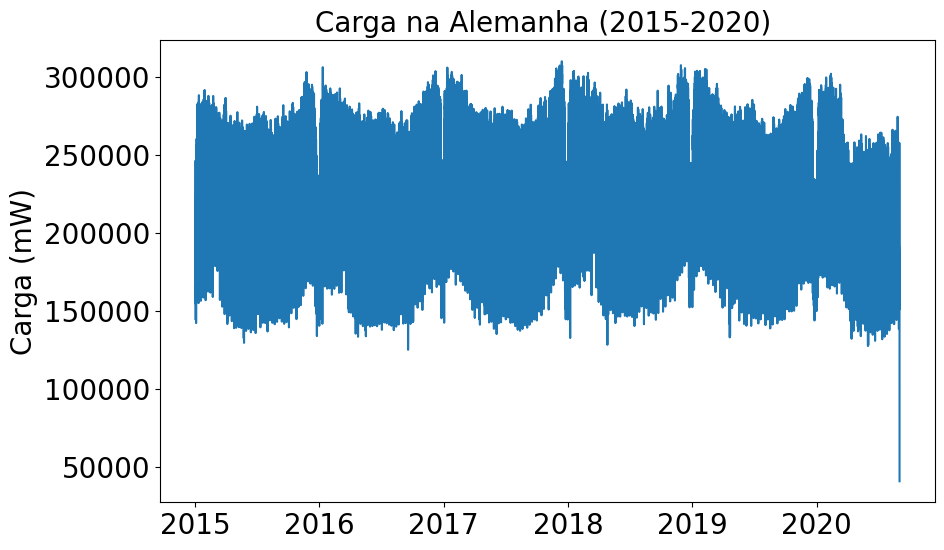

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_hourly_consumption.index, df_hourly_consumption['load'])
plt.ylabel("Carga (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Carga na Alemanha (2015-2020) ',fontsize=20)

### Função de Autocorrelação

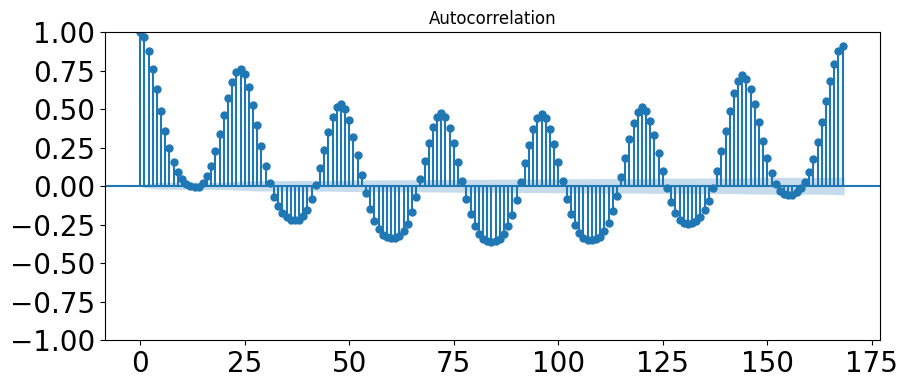

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

df = df_hourly_consumption.copy()
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(df['load'], lags=24*7, ax=ax)  # Lags para uma semana
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

### Boxplots

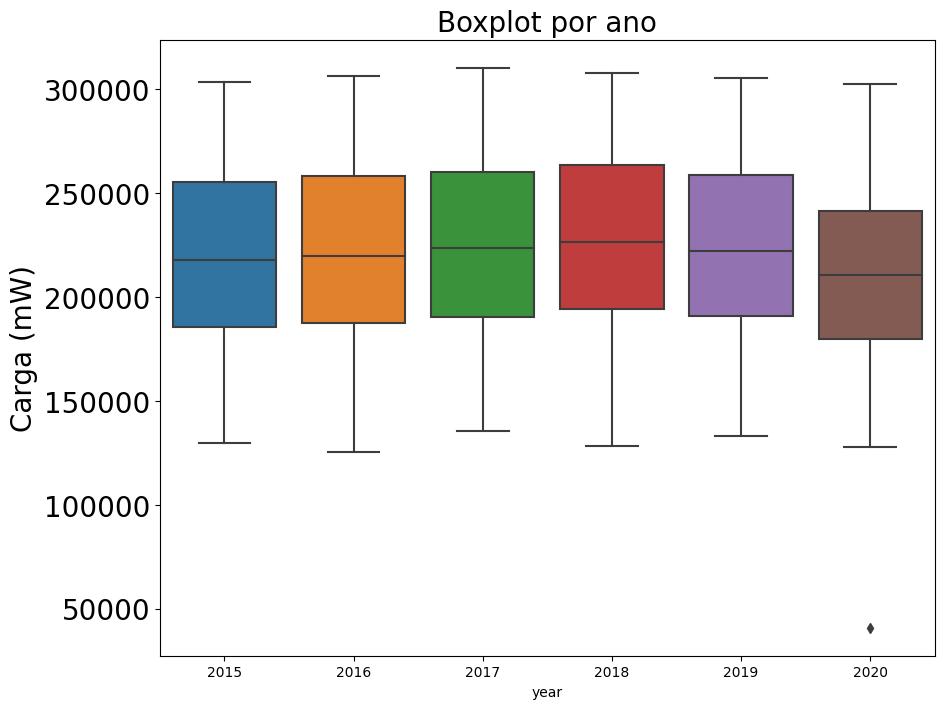

In [ ]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime("%b") for d in df.index]

plt.figure(figsize=(10,8))
sns.boxplot(x='year', y='load', data=df)
plt.ylabel("Carga (mW)", fontsize=20)
plt.yticks(fontsize=20)
plt.title('Boxplot por ano',fontsize=20)
plt.show()

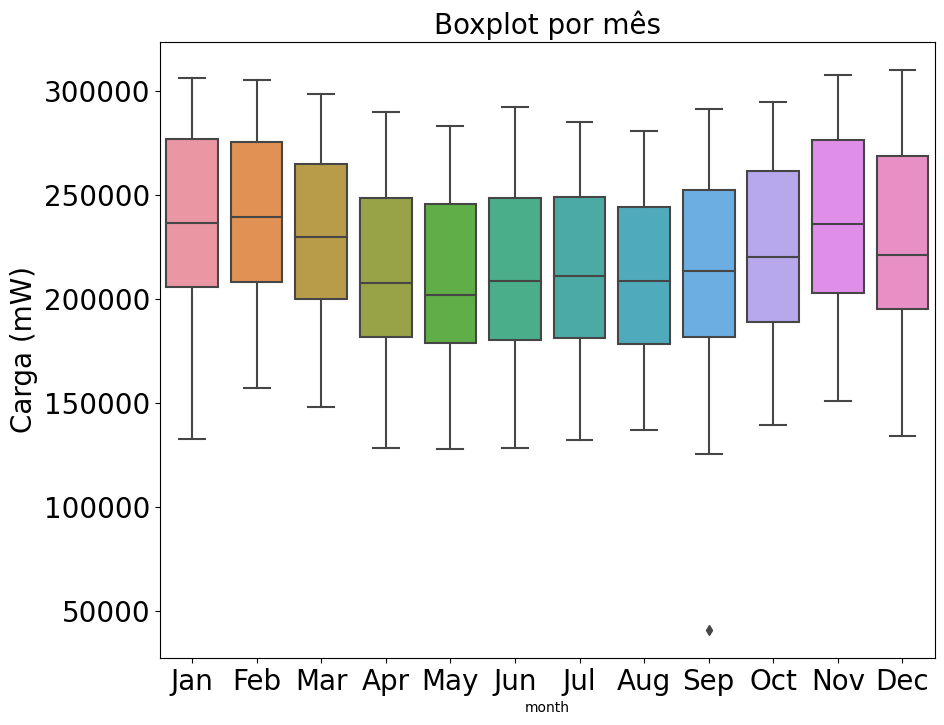

In [ ]:
plt.figure(figsize=(10,8))
sns.boxplot(x='month', y='load', data=df)
plt.ylabel("Carga (mW)", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Boxplot por mês',fontsize=20)
plt.show()


### Criação das sequências

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df_train[['load']])

df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

df_train_scaled['load'] = scaler.transform(df_train_scaled[['load']])
df_test_scaled['load'] = scaler.transform(df_test_scaled[['load']])


In [ ]:
last_n = 24

def to_sequences(x, y, last_n=24, seq_size=1):
    x_values = []
    y_values = []
    for i in range(len(x)-last_n-seq_size+1):
        x_values.append(x.iloc[i:(i+last_n)].values)
        y_values.append(y.iloc[i+last_n:i+last_n+seq_size].values)
    return np.array(x_values), np.array(y_values)

x_train, y_train = to_sequences(df_train_scaled[['load']], df_train_scaled['load'], last_n)
x_test, y_test = to_sequences(df_test_scaled[['load']], df_test_scaled['load'], last_n)

### LSTM

Alguns parâmetros de configuração:

* batch_size: determina o número de amostras de treinamento que são usadas em cada atualização do modelo.
* input_shape: tamanho dos dados de entrada. Deve estar no formato (n_steps, n_features)
* return_sequences: Quando igual a True, a camada LSTM retornará a saída completa para cada tempo de entrada, em vez de apenas a saída para o último tempo de entrada. Isso é útil quando você quer que a saída da LSTM seja usada como entrada para uma outra camada LSTM.
* Dropout: é uma técnica de regularização usada em modelos de aprendizado de máquina para prevenir o overfitting. Overfitting ocorre quando um modelo se ajusta demais aos dados de treinamento e não generaliza bem para novos dados. O Dropout ajuda a mitigar o overfitting ao "desligar" aleatoriamente alguns neurônios durante o treinamento, o que significa que a contribuição desses neurônios para a ativação de neurônios downstream é temporariamente *removida*


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 24, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 16)            2112      
                                                                 
 dropout_1 (Dropout)         (None, 24, 16)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 5393 (21.07 KB)
Trainable params: 5393 (21

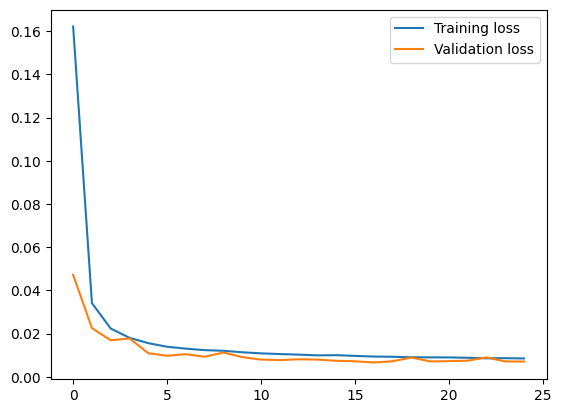

In [ ]:
model=Sequential()
model.add(LSTM(16,return_sequences=True,input_shape=(last_n,1)))
model.add(Dropout(0.1))
model.add(LSTM(16,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

plt.plot(history.history['loss'], label='Erro de treinamento')
plt.plot(history.history['val_loss'], label='Erro de validação')
plt.legend()


In [ ]:
#%%Predictions (LSTM)
train_predict = model.predict(x_train)
test_predict  = model.predict(x_test)

predict_train = scaler.inverse_transform(train_predict)
predict_test  = scaler.inverse_transform(test_predict)

388/388 [==============================] - 1s 3ms/step


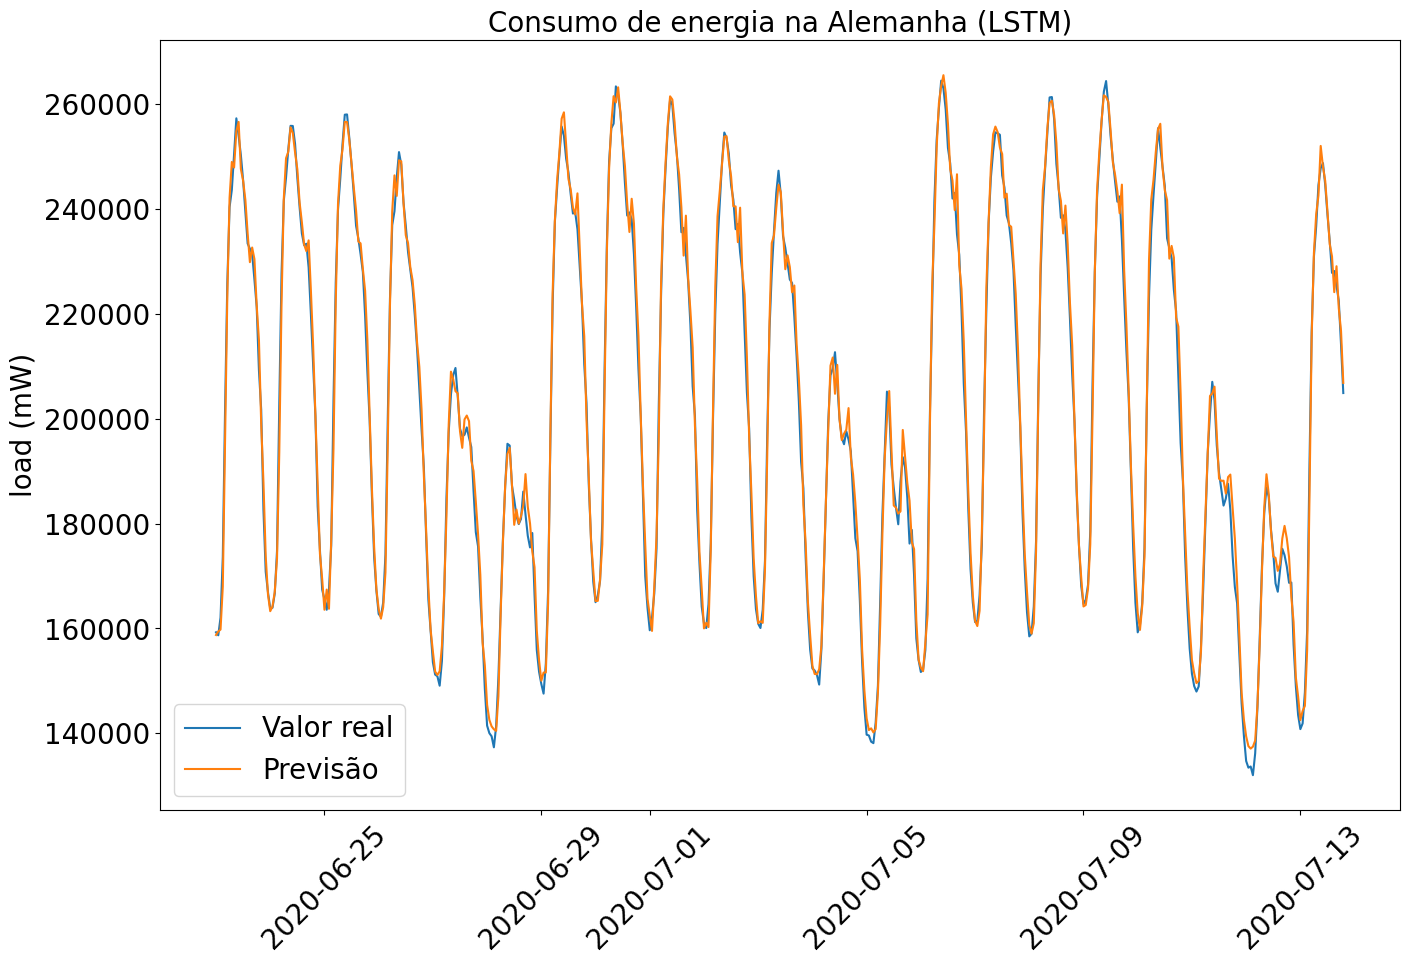

In [ ]:
# Visualização da previsão de um passo a frente
previous_days = last_n

testPredictPlot = np.empty_like(df['load'])
testPredictPlot[:] = np.nan
testPredictPlot = testPredictPlot.reshape(-1,1)
testPredictPlot[len(train_predict)+(previous_days*2):len(df), :] = predict_test

df_predict = pd.DataFrame(data=testPredictPlot, columns=['load'])
df_predict['start'] = df.index
df_predict['start'] = pd.to_datetime(df_predict['start'])
df_predict = df_predict.set_index("start")

df_real = df['load']

plt.figure(figsize=(10,8))
plt.plot(df_real[48000:48500],label='Valor real')
plt.xticks(rotation=45)
plt.ylabel("load (mW)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Consumo de energia na Alemanha (LSTM)',fontsize=20)
plt.plot(df_predict[48000:48500],label='Previsão')
plt.xticks(rotation=45)
plt.legend(fontsize=20)
plt.show()



### Avaliação do modelo

In [ ]:
real_y_test = scaler.inverse_transform(y_test)

mse = mean_squared_error(scaler.inverse_transform(y_test), predict_test)
nrmse = np.sqrt(mse)/np.mean(scaler.inverse_transform(y_test))
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test), predict_test)

print(f"{nrmse*100}%")
print(f"{mape*100}%")

1.5797040547938013%
1.2244573348862275%
